In [1]:
# -------------------------------------------------------------------------------------------------------------
# Imports
# -------------------------------------------------------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [3]:
# -------------------------------------------------------------------------------------------------------------
# System path for imports
# -------------------------------------------------------------------------------------------------------------
PROJECT_ROOT='./'
import sys
sys.path.append(PROJECT_ROOT)

## Experiment 1: CNN + Transformer Hybrid Architecture

Contains the hybrid architecture with element wise product of features

### CNN-ViT Hybrid Model

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Training Loop
# -------------------------------------------------------------------------------------------------------------

def train_no_patching(model, dataloader, optimizer, epochs=5, log_file='training_log.txt', best_model_dir='best_models/'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()

    os.makedirs(best_model_dir, exist_ok=True)
    best_loss = float('inf')

    # Define structures for capturing loss and epochs
    loss_history = []
    epoch_history = []

    # Open log file
    with open(log_file, 'w') as log:
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0

            for blurry, sharp in dataloader:
                blurry = blurry.to(device)
                sharp = sharp.to(device)

                optimizer.zero_grad()
                output = model(blurry)
                loss = criterion(output, sharp)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            loss_history.append(avg_loss)
            epoch_history.append(epoch)

            # Save best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), os.path.join(best_model_dir, 'best_model.pth'))

            # Logging
            log_line = f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}\n"
            print(log_line.strip())
            log.write(log_line)
            log.flush()

        # Visualization
        plt.plot(np.array(epoch_history), np.array(loss_history))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch for Pretrained CNN-ViT Hybrid with no patching")
        plt.show()






### Image patching

Channels, height and width: (3, 720, 1280)
[30, 36, 40, 45, 48, 60, 72, 80, 90, 120, 144, 180, 240, 360, 720]
[40, 64, 80, 128, 160, 256, 320, 640, 1280]
Rows Columns: (9, 8)
Patch Size: (80, 160)
72
8


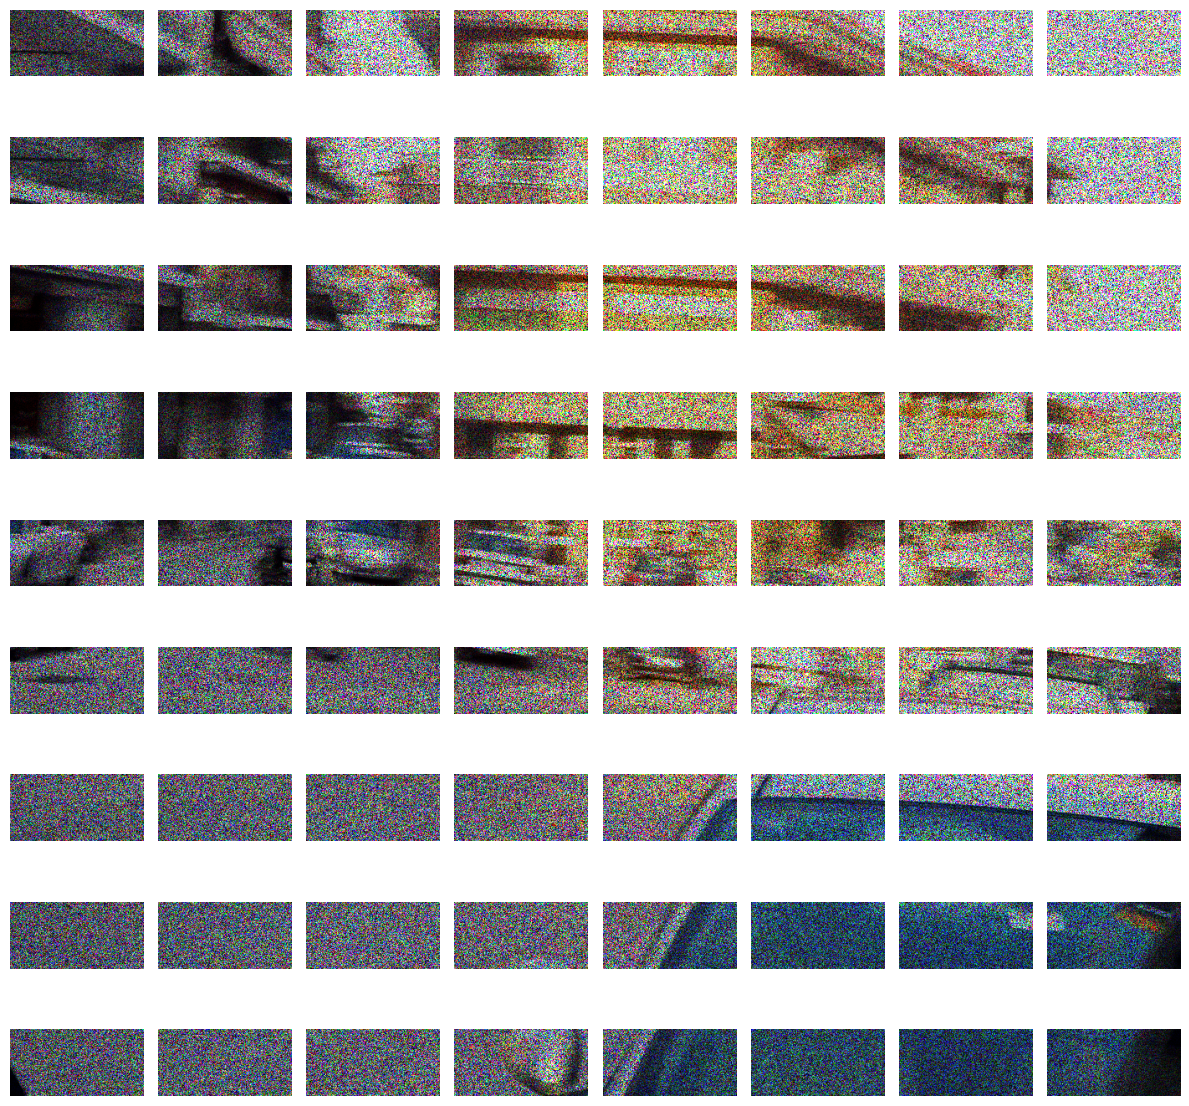

In [118]:
# -------------------------------------------------------------------------------------------------------------
# Factorization
# Calculate the factors and return the optimal number of rows and columns for patches
# -------------------------------------------------------------------------------------------------------------
from torchvision.transforms import ToPILImage
def factorization(number):
    factors = []

    for i in range(1, number+1):
        if number%i == 0:
            factors.append(i)
    
    middle_value = int(len(factors) / 2)
    factors = factors[middle_value:]
    middle = int(len(factors) / 2)
    partitions = int(number / factors[middle])
    patch_size = factors[middle]
    print(factors)
    return patch_size, partitions



# Preliminary transforms
transform = transforms.Compose([transforms.ToTensor()])
raw_image = Image.open("./Go_Pro_1.png").convert('RGB')
image = transform(raw_image)
C, H, W = image.shape
print(f"Channels, height and width: {C, H, W}")



# Factorize and choose maximum factor
if H == W:
    rows = columns = int(np.sqrt(H))
else:
    # call factorization method
    row_size, rows = factorization(H)
    column_size, columns = factorization(W)
    print(f"Rows Columns: {rows, columns}")
    print(f"Patch Size: {row_size, column_size}")

# -------------------------------------------------------------------------------------------------------------
# Patching
# -------------------------------------------------------------------------------------------------------------
img_patches = []
patches = []
for i in range(0, H, row_size):
    for j in range(0, W, column_size):
        patches.append(image[:, i: i+row_size, j: j+column_size])
        img_patches.append(ToPILImage()(image[:, i: i+row_size, j: j+column_size]))

print(len(patches[:]))

# -------------------------------------------------------------------------------------------------------------
# Stitching
# -------------------------------------------------------------------------------------------------------------
stitched_image = []
print(len(patches[:][:8]))
for i in range(0, len(patches[:]), columns):
    row = torch.cat(patches[:][i:i+columns], dim=2)
    stitched_image.append(row)

final_image = torch.cat(stitched_image, dim=1)
stitched_pil = ToPILImage()(final_image)
stitched_pil.show()


# -------------------------------------------------------------------------------------------------------------
# Plotting
# -------------------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(9, 8, figsize=(12, 12))
for ax, patch in zip(axs.flatten(), img_patches):
    ax.imshow(patch)
    ax.axis('off')

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/HLCV/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


CNN Features: torch.Size([512, 784]) = 512 channels, 28.0 height, width
Attention shape: torch.Size([1, 197, 197])
Attention Map reshaped: torch.Size([1, 1, 197, 197])
Attention Map after interpolation: torch.Size([1, 1, 512, 784])
Attention Map resized: torch.Size([1, 512, 512, 784])


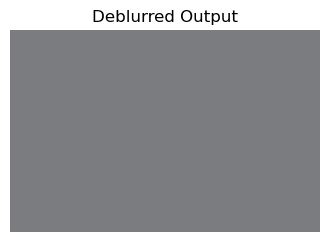

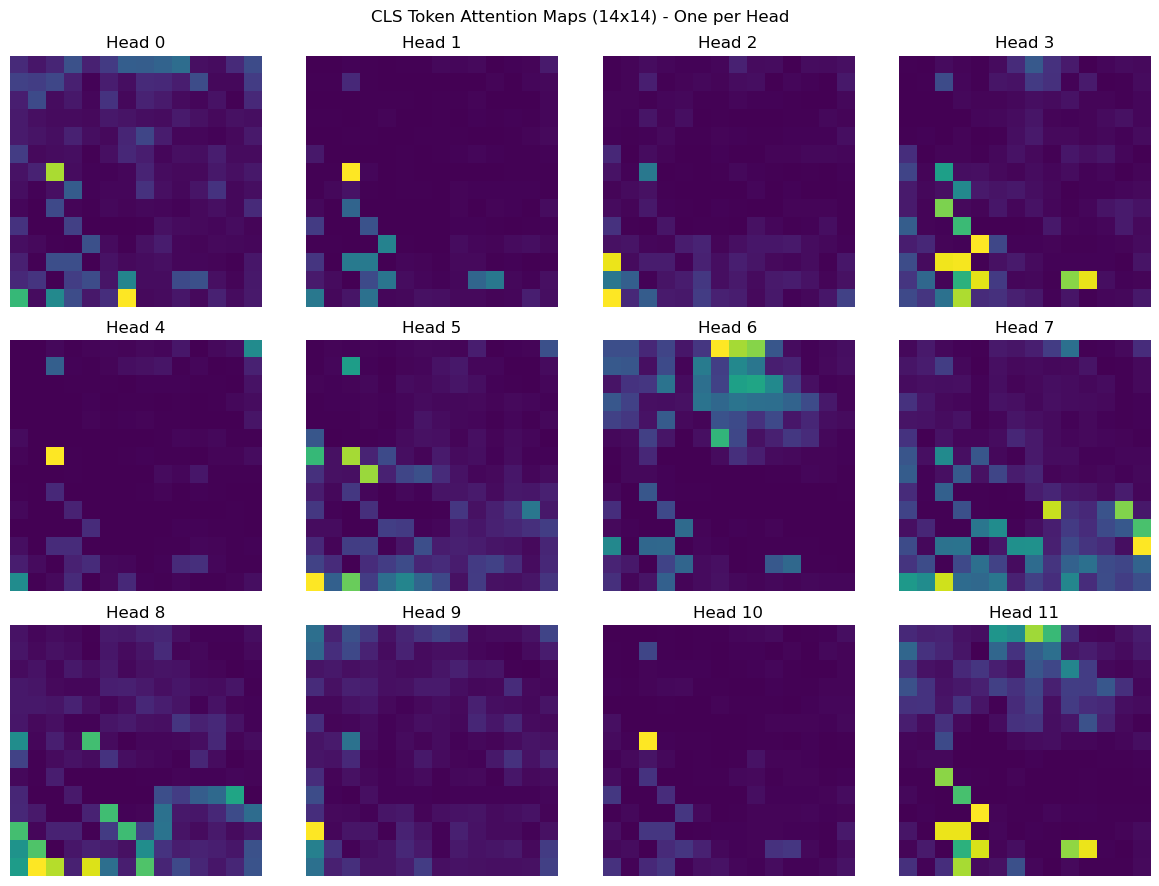

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Driver Code
# -------------------------------------------------------------------------------------------------------------
from architecture.cnn_vit_hybrid_architecture import CNN_VIT_HYBRID_ARCHITECTURE

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
raw_image = Image.open("./Blur.png").convert('RGB')
image = transform(raw_image)


# -------------------------------------------------------------------------------------------------------------
# Run experiments
# -------------------------------------------------------------------------------------------------------------
model = CNN_VIT_HYBRID_ARCHITECTURE()
model(image)